### <p style="text-align: right;"> &#9989; Eric Ropeta </p>
#### <p style="text-align: right;"> &#9989; Put your group member names here</p>

# Day 17 In-Class Assignment: Principal Component Analysis (PCA)

<img src="http://lazyprogrammer.me/wp-content/uploads/2015/11/PCA.jpg" width="400"><a href="http://lazyprogrammer.me/tutorial-principal-components-analysis-pca//"><p style="text-align: right;">
Image from http://lazyprogrammer.me/
</p></a>

PCA Explained Visually: [http://setosa.io/ev/principal-component-analysis/](http://setosa.io/ev/principal-component-analysis/)


1. **Scientific motivation** 
    - Biometrics (Pattern Recognition)
2. **Modeling tools** 
    - Principal Component Analysis (PCA) for feature selection
3. **Programming concepts** 
    - Code Review
4. **Python Programming Concepts** 
    - Saving objects using the pickle library
    


# Problem Description
In Machine Learning, a good "rule of thumb" is to have more than 10 times the number of training samples as dimensions in your feature vector.  So if your feature vector has 4 features, then you should have 40 samples for training (this doesn't count the samples for testing).

This is also called the "curse of dimensionality" and can sometimes be counter intuitive.  Basically we want more dimensions to ensure that we have captured the patterns we want to learn in the model. However, too many dimensions requires more training data. This can be a big problem when you have high dimensional data. 

For example, the face images provided by sci-kit learn, which we visited briefly at the end of the last class period and are using today in class, have 50 rows and 37 columns; this results in a vector length of 1850.  By the Machine Learning rule of thumb, we should have 18,500 examples in our training set (we only have at most 1560 examples and that does not include the ones we have set aside for testing. Many of you saw what happened when we ignored this rule.

In this assignment we are going to use Principal Component Analysis (PCA) to to reduce the size of our feature vector and only select features which are the "most" descriptive.

### Agenda for today's class

</p>

1. Review of Face Recognition from last time
1. Pre-class assignment review
1. Feature Selection using Principal Component Analysis
1. Picking the best Feature Vectors
1. Eigenfaces (just for fun -- and knowledge!)


---
# 1. Review of Face Recognition from last time

&#9989; For each of the following steps; run the code and discuss as a group what the code is doing.  As a class we will continue the discussion. 

First, lets download and view the data:

In [10]:
#Import the data from scikit-learn
import numpy as np
from sklearn.datasets import fetch_lfw_people, load_digits

sk_data = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names
n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

In [11]:
%matplotlib inline
import matplotlib.pylab as plt
from ipywidgets import interact

def browse_images(images, labels, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
browse_images(sk_data.images, sk_data.target, sk_data.target_names)

interactive(children=(IntSlider(value=779, description='i', max=1559), Output()), _dom_classes=('widget-intera…

## Step 1: Splitting the dataset into training and testing sets

Let's split the data into a training and testing set using the ```train_test_split``` function:

In [12]:
from sklearn.model_selection import train_test_split
# Note, if you have an older version of scikit-learn,
# you might need to replace the above line with the one below
#from sklearn.cross_validation import train_test_split

train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, 
                                                                          class_labels, 
                                                                          random_state=1,
                                                                          test_size=0.25)
print(len(train_vectors))
print(len(test_vectors))
print(test_vectors, test_labels)

1170
390
[[110.333336 110.666664 113.666664 ... 207.       227.66667  232.33333 ]
 [239.33333  224.66667  128.       ...  77.       110.       168.66667 ]
 [ 88.        98.333336  66.333336 ... 234.33333  238.66667  152.66667 ]
 ...
 [113.       121.333336 120.       ...  68.333336  67.333336  70.333336]
 [ 68.333336  74.333336  97.       ... 186.       163.       108.333336]
 [ 60.        58.        55.333332 ... 114.       126.333336 142.33333 ]] [ 1  1  3  3  3 11  3  0  3  4  3  3  2  3  1 11  3  4  1  1  3  5  3  3
  2  3  3  2  3  3  5  3  2  3  3  9  4  0 10  5  9  1  1  1  1  4  1  3
  3  2 11  3  9  1  2  3  3  8  8 11 11  2  6  8 10  3  3  3  3  3 11  1
 10 10  2  3  3  5  7  1  3  1  0 11 11  3  3  8  1  6  3 11  3  3  7  1
  9  6  3  9  4  9  3  3  1  3  9  3  3  3  2  1  1  5  8  3  3  3 11  3
 10  1  6  7  9  1  1  3  3  4  3  7  0  0  7  3  3  4  2  3  0  3 10  0
  3  3  4  1  1  3  4  3  3  3 11  1  7 10  3  3  3 11  3  3  5  5  9  9
 11  7  3  7 11  7  3  0  5 10  4  3

## Step 2: Train an SVM Classifier based on the training dataset.

As we learned in the last class.  This training step can take a while (more than 5 minutes, depending on your computer).  To save some time, the instructors modified the code from last time to save the results of the training data to a file and saved this file in the class git repository.  You can used the saved data by setting ```rerun_training``` to `False` or, if you want, you can redo the training step by setting ```rerun_training``` to `True.

In [16]:
rerun_training = True
filename = 'full_face_model.p'

In [17]:
# Train a SVM classification model  NOTE This can take ~ 5 minutes or more!!!!
from sklearn.model_selection import GridSearchCV
# If you have an old version of sklearn that you have upgraded yet,
# you will need to change the above import to the one below
# from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import pickle
import time

#make some temporary variables so you can change this easily
tmp_vectors = train_vectors
tmp_labels = train_labels

In [18]:
start = time.time()
if rerun_training:
    
    print("Fitting the classifier to the training set")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(tmp_vectors, tmp_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    #save the model to a file
    pickle.dump(clf, open(filename, 'wb'))

else:
    #read the model from a file
    print("reading pickle file.")
    clf = pickle.load(open(filename, 'rb'))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
end = time.time()
print("Runtime",end - start)
    

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)
Runtime 131.4863622188568


**Question**: What library and functions are used to save and load a python object in this example?  

```pickle.dump(clf, open(filename, 'wb'))``` and ```pickle.load(open(filename, 'rb'))``` from the ```pickle``` library!

## Step 3. Show the results of the classification on the testing dataset.

In [19]:
# Quantitative evaluation of the model quality on the test set

#make some temporary variablse so you can change this easily
predict_vectors = test_vectors
true_labels = test_labels

In [20]:
print("Predicting people's names on the test set")
pred_labels = clf.predict(predict_vectors)

print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels, labels=range(n_classes)))

Predicting people's names on the test set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00        22
           3       0.36      1.00      0.53       141
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00        37

    accuracy                           0.36       390
   macro avg       0.03      0.08      0.04       390
weighted avg       0.13      0.36      0.19       390

[[  0   0   0  18   0   0   0   0   0   0   0   0]
 [  0   0   0  65   0   0   0   0   0   

/home/moose/Documents/Jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moose/Documents/Jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/moose/Documents/Jupyter/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


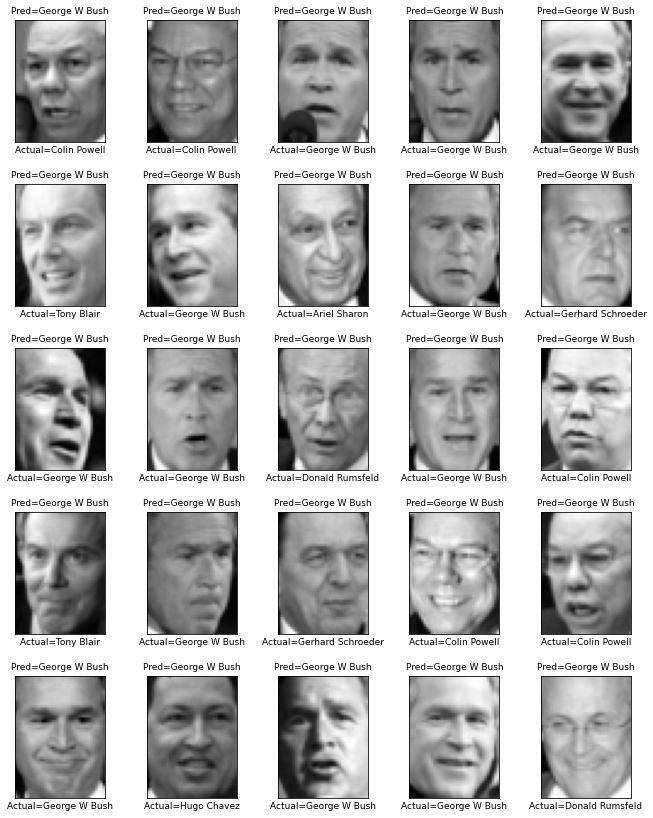

In [21]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title('Pred='+str(categories[pred_titles[i]]), size=9)
        plt.xlabel('Actual='+str(categories[true_titles[i]]), size=9)
        plt.xticks(())
        plt.yticks(())

plot_gallery(test_vectors, test_labels, pred_labels, h,w)

---
# 2. Review of pre-class assignment

----

# 3. Feature Selection using Principal Component Analysis

Now we are going to go through the entire program above and use Principal Component Analysis (PCA) to select a much smaller set of better features.   The following code will reduce the original picture feature vector to a feature vector with 4 (n_components).  This is often called unsupervised feature extraction:

In [22]:
from sklearn.decomposition import PCA

n_components = 4 # This is much less than the original n_features

print("Extracting the top %d eigenfaces from %d faces" % (n_components, train_vectors.shape[0]))

#Set up the pca object with the number of compoents we want to find
pca = PCA(n_components=n_components, whiten=True)

#Fit the training data to the pca model.
_ = pca.fit(train_vectors)

Extracting the top 4 eigenfaces from 1170 faces


We now have a ```pca``` object that has our data fit to it.  We can use this object to transform the original training vectors consisting of the entire image into new training vectors using the ```transform``` function:

In [23]:
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

print("Training set changed from a size of: ", train_vectors.shape, ' to: ', pca_train_vectors.shape)
print("Testing set changed from a size of: ", test_vectors.shape, ' to: ', pca_test_vectors.shape)

Training set changed from a size of:  (1170, 1850)  to:  (1170, 4)
Testing set changed from a size of:  (390, 1850)  to:  (390, 4)


&#9989; **DO THIS:** We have now reduced the size of our feature vectors.  Modify the code in **Section 1** to substitute these two new reduced size vectors for the full size vectors.  This modification should replace both the training vectors and the testing vectors. Make sure you also consider the following:

* Recalculate the clf model and do not load it from memory -- **this is important!**
* You probably want to **change the filename so you do not overwrite the instructors file**
* Make sure your changes ensure that **the tmp_vectors and predict_vectors reference the new smaller vectors**

In [26]:
tmp_vectors = pca_train_vectors
tmp_labels = train_labels

rerun_training = True
filename = 'pca_full_face_model.p'

In [27]:
start = time.time()
if rerun_training:
    
    print("Fitting the classifier to the training set")
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(tmp_vectors, tmp_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    #save the model to a file
    pickle.dump(clf, open(filename, 'wb'))

else:
    #read the model from a file
    print("reading pickle file.")
    clf = pickle.load(open(filename, 'rb'))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
end = time.time()
print("Runtime",end - start)


Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=50000.0, class_weight='balanced', gamma=0.1)
Runtime 197.14603352546692


In [28]:
predict_vectors = pca_test_vectors
true_labels = test_labels

print("Predicting people's names on the test set")
pred_labels = clf.predict(predict_vectors)

print(classification_report(true_labels, pred_labels))
print(confusion_matrix(true_labels, pred_labels, labels=range(n_classes)))

Predicting people's names on the test set
              precision    recall  f1-score   support

           0       0.10      0.22      0.14        18
           1       0.26      0.18      0.21        65
           2       0.11      0.18      0.13        22
           3       0.52      0.33      0.40       141
           4       0.03      0.05      0.03        22
           5       0.14      0.15      0.15        20
           6       0.00      0.00      0.00         9
           7       0.12      0.14      0.13        14
           8       0.00      0.00      0.00        11
           9       0.31      0.26      0.29        19
          10       0.55      0.50      0.52        12
          11       0.08      0.08      0.08        37

    accuracy                           0.22       390
   macro avg       0.18      0.17      0.17       390
weighted avg       0.29      0.22      0.25       390

[[ 4  5  3  1  0  0  1  0  1  0  0  3]
 [10 12  3 12  6  3  3  3  5  1  1  6]
 [ 2  3  4  1

**Question**:  What precision can the SVM algorithm achieve with only the first 4 feature vectors?  And how long did this take to run?

It only took 197 seconds to run, and it can achieve a precision of about 0.22 on average, which is higher than with all the other features.

# 4. Picking the "best" Feature Vectors
If you remember from your pre-class assignment the PCA algorithm finds a transform of the data such that the first component contains the "most" information the second component contains the "second most" important information.  How much information each component contains is actually included in the ```pca``` object and can be expressed as a ratio from 0 (no information) to 1 (all information).  Lets plot these values below:

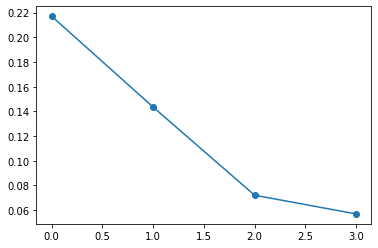

In [29]:
#Lets plot the variance of the eigen values
plt.plot(pca.explained_variance_ratio_, marker="o")

Another way to look at this is we can sum up the total ratios and see how much our new set of features represents the "variance" in the original data:

In [30]:
total_variance = np.sum(pca.explained_variance_ratio_)*100
print("These %d eigenvectors account for a total of %d percent of the total variance in the original dataset"
      % (n_components, total_variance))


These 4 eigenvectors account for a total of 48 percent of the total variance in the original dataset


**Question:** How many components would we need to represent 90% of the variance in our original data? (Hint: modify **Section 3** and change n_components to find a total_variance > 90)

we'd need 75 components to represent 90% of the variance in our original data

----
# 5. Eigenfaces (just for fun and knowledge)

An eigenvector is a transform from the original image space into a new space along a single axis.  You can actually think of these vectors as a weighted sum of the components of an original image. So the length of the eigenvectors are the same size as the original data. Let's plot the gallery of the most significant eigenvectors:

In [20]:
eigenfaces = pca.components_.reshape((n_components, h, w))

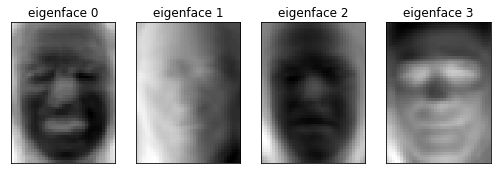

In [21]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row=1, n_col=4)

These vectors are often called eigenfaces.  Each image gives you information about where the greatest amount of variation occurs in the images. Some of the eigenfaces tell you more about the lighting in the image or about the orientation of the face and less about the actual facial features, but others highlight where the most variation is from face to face.

----

-----
### Congratulations, we're done!

Now, you just need to submit this assignment by uploading it to the course <a href="https://d2l.msu.edu/">Desire2Learn</a> web page for today's submission folder (Don't forget to add your names in the first cell).


&#169; Copyright 2018,  Michigan State University Board of Trustees